In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# ============================================================
# RoBERTa-large | TweetEval Sentiment (3-class)
# FINAL VERSION-SAFE, ERROR-FREE CODE
# ============================================================

!pip install -q transformers datasets accelerate scikit-learn torch matplotlib seaborn emoji

import re
import emoji
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    TrainerCallback,
    set_seed
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -------------------------
# Load Dataset
# -------------------------
dataset = load_dataset(
    "csv",
    data_files="/kaggle/input/d2-for-roberta-large/tweet_eval_sentiment_full.csv"
)
dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)
train_ds, val_ds = dataset["train"], dataset["test"]

print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))

# -------------------------
# Text Cleaning (NO emojis)
# -------------------------
def clean_text(text):
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

train_ds = train_ds.map(lambda x: {"tweet": clean_text(x["tweet"])})
val_ds   = val_ds.map(lambda x: {"tweet": clean_text(x["tweet"])})

# -------------------------
# Tokenization
# -------------------------
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-large")

def tokenize(batch):
    return tokenizer(
        batch["tweet"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
val_ds   = val_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# -------------------------
# Class Weights
# -------------------------
labels_np = np.array(train_ds["labels"])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_np),
    y=labels_np
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# -------------------------
# Custom Trainer (API SAFE)
# -------------------------
class WeightedTrainer(Trainer):
    def compute_loss(
        self,
        model,
        inputs,
        return_outputs=False,
        num_items_in_batch=None
    ):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(
            weight=class_weights.to(logits.device)
        )
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# -------------------------
# Validation Metrics
# -------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

# -------------------------
# Training Accuracy Callback (SAFE METHOD)
# -------------------------
class TrainAccuracyCallback(TrainerCallback):
    def __init__(self):
        self.trainer = None
        self.train_acc = []

    def on_epoch_end(self, args, state, control, **kwargs):
        model = self.trainer.model
        model.eval()

        preds_all, labels_all = [], []
        with torch.no_grad():
            for batch in self.trainer.get_train_dataloader():
                batch = {k: v.to(model.device) for k, v in batch.items()}
                outputs = model(**batch)
                preds = torch.argmax(outputs.logits, dim=1)
                preds_all.extend(preds.cpu().numpy())
                labels_all.extend(batch["labels"].cpu().numpy())

        acc = accuracy_score(labels_all, preds_all) * 100
        self.train_acc.append(acc)

# -------------------------
# Model
# -------------------------
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-large",
    num_labels=3
)

# -------------------------
# Training Arguments (ONLY 3 epochs)
# -------------------------
training_args = TrainingArguments(
    output_dir="./roberta_large_final",
    overwrite_output_dir=True,
    num_train_epochs=3,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="none"
)

# -------------------------
# Trainer (MANUAL CALLBACK INJECTION)
# -------------------------
train_acc_cb = TrainAccuracyCallback()

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1), train_acc_cb]
)

# 🔑 CRITICAL LINE (fixes KeyError forever)
train_acc_cb.trainer = trainer

# -------------------------
# Train
# -------------------------
trainer.train()

# ============================================================
# FINAL EVALUATION
# ============================================================

val_out = trainer.predict(val_ds)
y_true = val_out.label_ids
y_pred = np.argmax(val_out.predictions, axis=1)

# -------------------------
# Class-wise Metrics
# -------------------------
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average=None
)

class_accuracy = [
    accuracy_score(y_true[y_true == i], y_pred[y_true == i])
    for i in range(3)
]

print("\nClass-wise Metrics:")
for i, cls in enumerate(["Negative", "Neutral", "Positive"]):
    print(
        f"{cls} -> Accuracy={class_accuracy[i]:.4f}, "
        f"Precision={precision[i]:.4f}, "
        f"Recall={recall[i]:.4f}, "
        f"F1={f1[i]:.4f}"
    )

# -------------------------
# Confusion Matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Negative","Neutral","Positive"],
    yticklabels=["Negative","Neutral","Positive"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# -------------------------
# Curves: LOSS & ACCURACY
# -------------------------
train_loss, val_loss, val_acc = [], [], []

for log in trainer.state.log_history:
    if "loss" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        val_acc.append(log["eval_accuracy"] * 100)

epochs = range(1, len(val_acc) + 1)

# Loss Curve
plt.figure(figsize=(7,5))
plt.plot(epochs, train_loss[:len(epochs)], label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()

# Accuracy Curve
plt.figure(figsize=(7,5))
plt.plot(epochs, train_acc_cb.train_acc[:len(epochs)], label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_curve.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nSaved PNG files:")
print("confusion_matrix.png")
print("loss_curve.png")
print("accuracy_curve.png")


In [5]:
import pandas as pd

data = {
    "Accuracy":  [0.8388, 0.6613, 0.8309],
    "Precision": [0.6763, 0.7956, 0.7612],
    "Recall":    [0.8388, 0.6613, 0.8309],
    "F1-Score":  [0.7489, 0.7222, 0.7945]
}

labels = ["Negative", "Neutral", "Positive"]

df = pd.DataFrame(data, index=labels)
df


,Accuracy,Precision,Recall,F1-Score
Negative,0.8388,0.6763,0.8388,0.7489
Neutral,0.6613,0.7956,0.6613,0.7222
Positive,0.8309,0.7612,0.8309,0.7945


In [6]:
df.to_csv("classwise_metrics.csv")
print("classwise_metrics.csv saved")


classwise_metrics.csv saved


In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os

base_path = "/kaggle/input"

# find your uploaded folder name
print(os.listdir(base_path))


['d2-for-roberta-large', 'output']


(np.float64(-0.5), np.float64(669.5), np.float64(602.5), np.float64(-0.5))

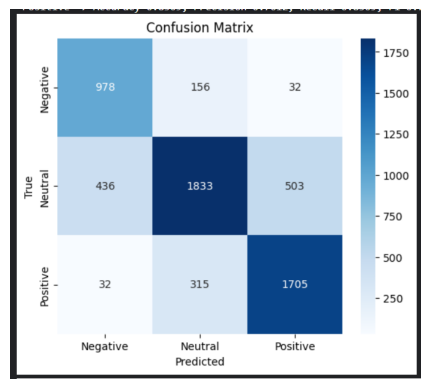

In [2]:
img = Image.open("/kaggle/input/output/Confusion_matrix.png")
plt.imshow(img)
plt.axis("off")


(np.float64(-0.5), np.float64(789.5), np.float64(598.5), np.float64(-0.5))

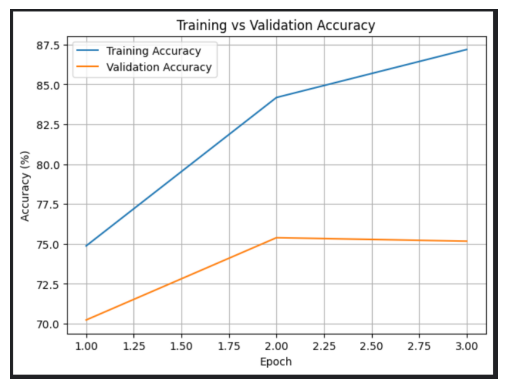

In [4]:
img = Image.open("/kaggle/input/output/accuracy_curve.png")
plt.imshow(img)
plt.axis("off")

(np.float64(-0.5), np.float64(784.5), np.float64(595.5), np.float64(-0.5))

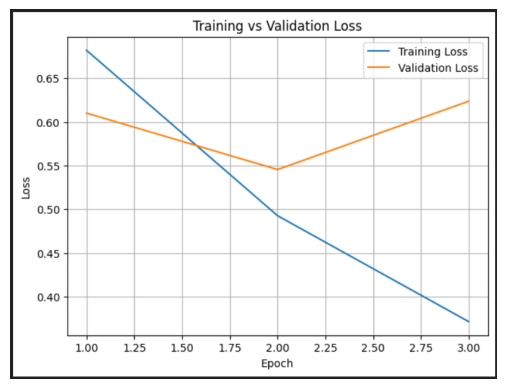

In [3]:
img = Image.open("/kaggle/input/output/Loss_Curve.png")
plt.imshow(img)
plt.axis("off")